In [1]:
from nltk.stem.snowball import SnowballStemmer
import codecs
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import re


In [2]:
data=pd.DataFrame(columns=['Text','Class']) 
for folders in os.listdir(os.getcwd()):
    cnt=0
    for file in os.listdir(folders):
        data=data.append({'Text':codecs.open('./'+folders+'/'+file,encoding='utf8',\
                    errors='replace').read(),'Class':folders},ignore_index=True)
        cnt+=1
    print(folders,cnt)

sport 511
entertainment 386
business 510
politics 417
tech 401


In [103]:
data.head()

,Text,Class,class_num,token
0,Galloway plea for hostage release\n\nEx-Labour...,politics,2,galloway plea hostag releas ex-labour georg ga...
1,Film star Fox behind theatre bid\n\nLeading ac...,entertainment,4,film star fox behind theatr bid lead actor edw...
2,Blair to face trust issue head on\n\nTony Blai...,politics,2,blair face trust issu head toni blair say face...
3,"Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...",business,3,steel firm cut job mittal steel one world larg...
4,Broadband in the UK growing fast\n\nHigh-speed...,tech,0,broadband grow fast high-spe net connect prove...


In [101]:
print(data.shape)

(2225, 4)


In [4]:
Classes=['tech','sport','politics','business','entertainment']

data['class_num']=[0 if label=='tech' else 1 if label=='sport' else 2 if\
        label=='politics' else 3 if label=='business' else 4 for label in data['Class'] ]

data=data.sample(frac=1).reset_index(drop=True)
data.to_csv('data.csv',index=False)

In [5]:
data.head()

,Text,Class,class_num
0,Galloway plea for hostage release\n\nEx-Labour...,politics,2
1,Film star Fox behind theatre bid\n\nLeading ac...,entertainment,4
2,Blair to face trust issue head on\n\nTony Blai...,politics,2
3,"Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...",business,3
4,Broadband in the UK growing fast\n\nHigh-speed...,tech,0


In [6]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

In [73]:
from nltk.corpus import stopwords

stopWords=stopwords.words('english')
stopWords.extend(['said','the','say','would'])

In [74]:
all_word=pd.DataFrame(columns=['word'])
data['token']=''


for idx,sentence in enumerate(data['Text']):
    sentence=re.sub("[(),!?@\'\`\"\_:.#%]",'',sentence)
    sentence=re.sub("http\S+",'',sentence)
    sentence=re.sub("@\S+",'',sentence)
    sentence=re.sub('[0-9]+\S+','',sentence)
    sentence=re.sub("\n",' ',sentence)
    tmp,tmp1=zip(*[(stemmer.stem(word),word) for word in sentence.split() if len(word)>2and word not in stopWords] )
    all_word=all_word.append(pd.DataFrame({'word':tmp1},index=tmp))
    data['token'][idx]=' '.join(tmp)


/home/aninda/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [75]:
data.head()

,Text,Class,class_num,token
0,Galloway plea for hostage release\n\nEx-Labour...,politics,2,galloway plea hostag releas ex-labour georg ga...
1,Film star Fox behind theatre bid\n\nLeading ac...,entertainment,4,film star fox behind theatr bid lead actor edw...
2,Blair to face trust issue head on\n\nTony Blai...,politics,2,blair face trust issu head toni blair say face...
3,"Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...",business,3,steel firm cut job mittal steel one world larg...
4,Broadband in the UK growing fast\n\nHigh-speed...,tech,0,broadband grow fast high-spe net connect prove...


In [76]:
print('Most Frequent Words = >\n',
      pd.Series(all_word.index.tolist()).value_counts()[:15])

Most Frequent Words = >
 the       8019
year      2833
also      2156
peopl     2044
new       1970
one       1811
but       1788
game      1639
use       1561
could     1510
time      1487
last      1404
make      1375
first     1290
govern    1246
dtype: int64


In [77]:
all_word=all_word.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

In [78]:
print('Vocabulary size :',len(all_word))

Vocabulary size : 21861


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.colors as col
import matplotlib.patches as mpatches

In [80]:
labels=data['class_num']
text=data['token']

In [98]:
def plot_LSA(data,labels,legends_list,num_clusters=5):

    lsa = TruncatedSVD(n_components=3)

    lsa_scores = lsa.fit_transform(data)

    cluster_colors = ['darkgreen','yellow','#7570b3','#e7298a','deepskyblue']
    tmp=[]

    for class_idx in range(num_clusters):
        tmp.append(mpatches.Patch(color=cluster_colors[class_idx], label=' '.join(legends_list[class_idx])))

    fig=plt.figure(figsize=(18, 15))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    a=ax.scatter(lsa_scores[:, 0],lsa_scores[:, 1],lsa_scores[:, 2],c=labels,\
        cmap=col.ListedColormap(cluster_colors))

    plt.legend(handles=tmp,prop={'size': 15})
    plt.show()

In [92]:
tfidf_vec=TfidfVectorizer(stop_words=stopWords)
text_tfidf=tfidf_vec.fit_transform(text)

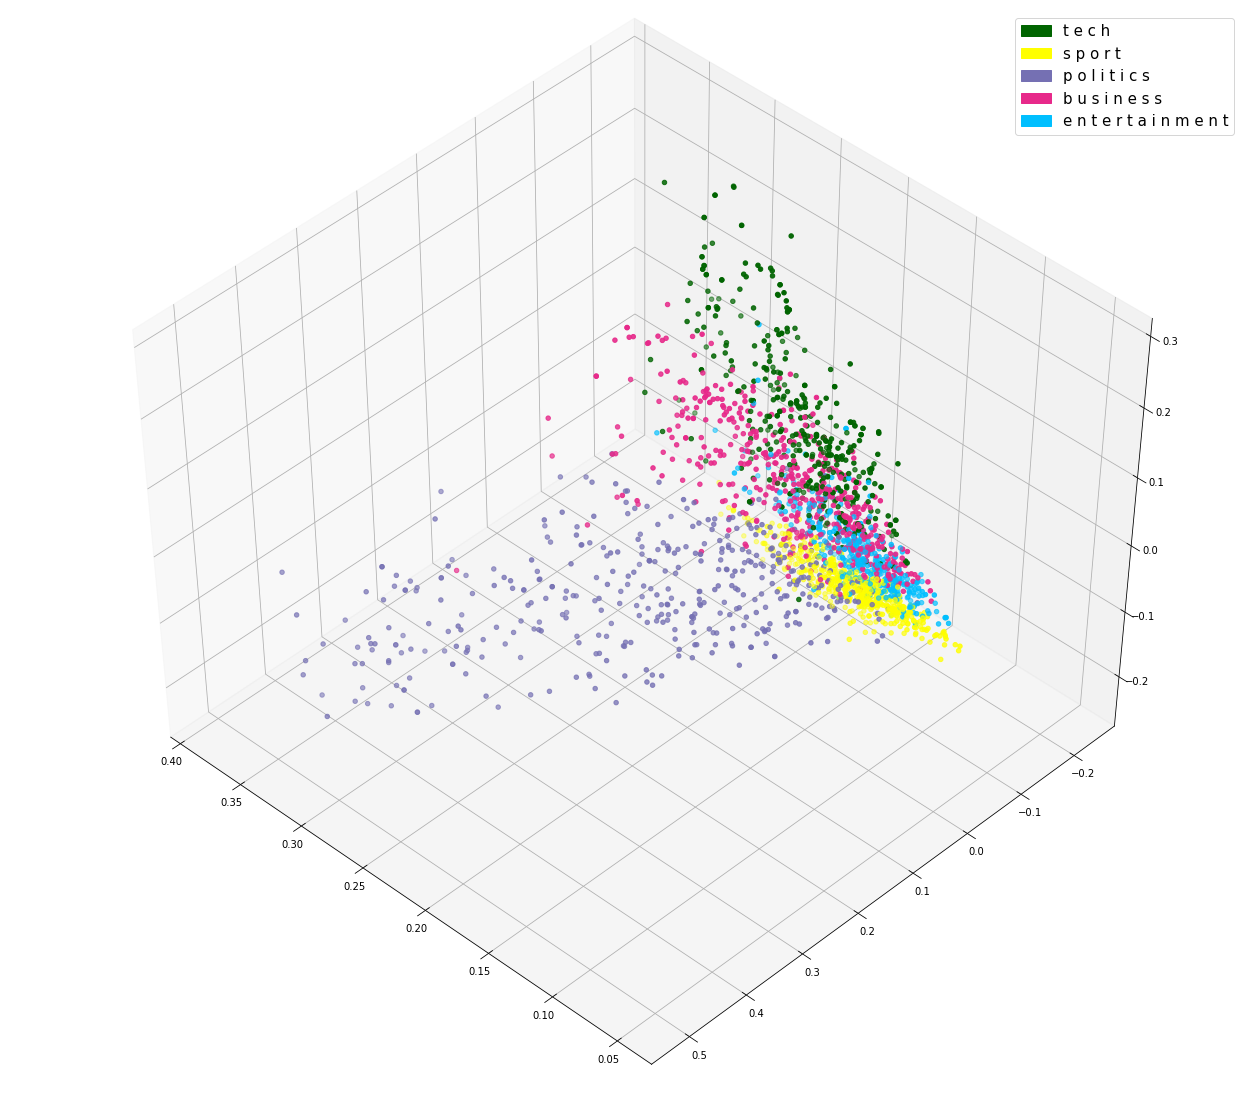

In [99]:
plot_LSA(text_tfidf,labels,Classes)

In [84]:
from sklearn.cluster import KMeans

In [94]:
num_clusters=5
km_tfidf=KMeans(n_clusters=num_clusters,n_jobs=-1,max_iter=450)
km_tfidf.fit(text_tfidf)
cluster_tfidf=km_tfidf.labels_.tolist()
cluster_centers_tfidf = km_tfidf.cluster_centers_.argsort()[:, ::-1]

In [95]:
index_to_word_tfidf = {idx:word for word,idx in tfidf_vec.vocabulary_.items()}


In [96]:
feature_word=[]
for cluster_idx in range(num_clusters):
    print("Cluster %d words:" % cluster_idx, end=' ')
    cluster_word=[]
    for word_idx in cluster_centers_tfidf[cluster_idx, :6]:
        cluster_word.append(all_word['word'][index_to_word_tfidf[word_idx]])
        print(all_word['word'][index_to_word_tfidf[word_idx]],end=" ")
    feature_word.append(cluster_word)
         
    print()

Cluster 0 words: election Labour party Blair Tories Browns 
Cluster 1 words: Film awarded best star Oscar nominated 
Cluster 2 words: game played win England players match 
Cluster 3 words: Mobile used phone game people technology 
Cluster 4 words: years company banks government sales firm 


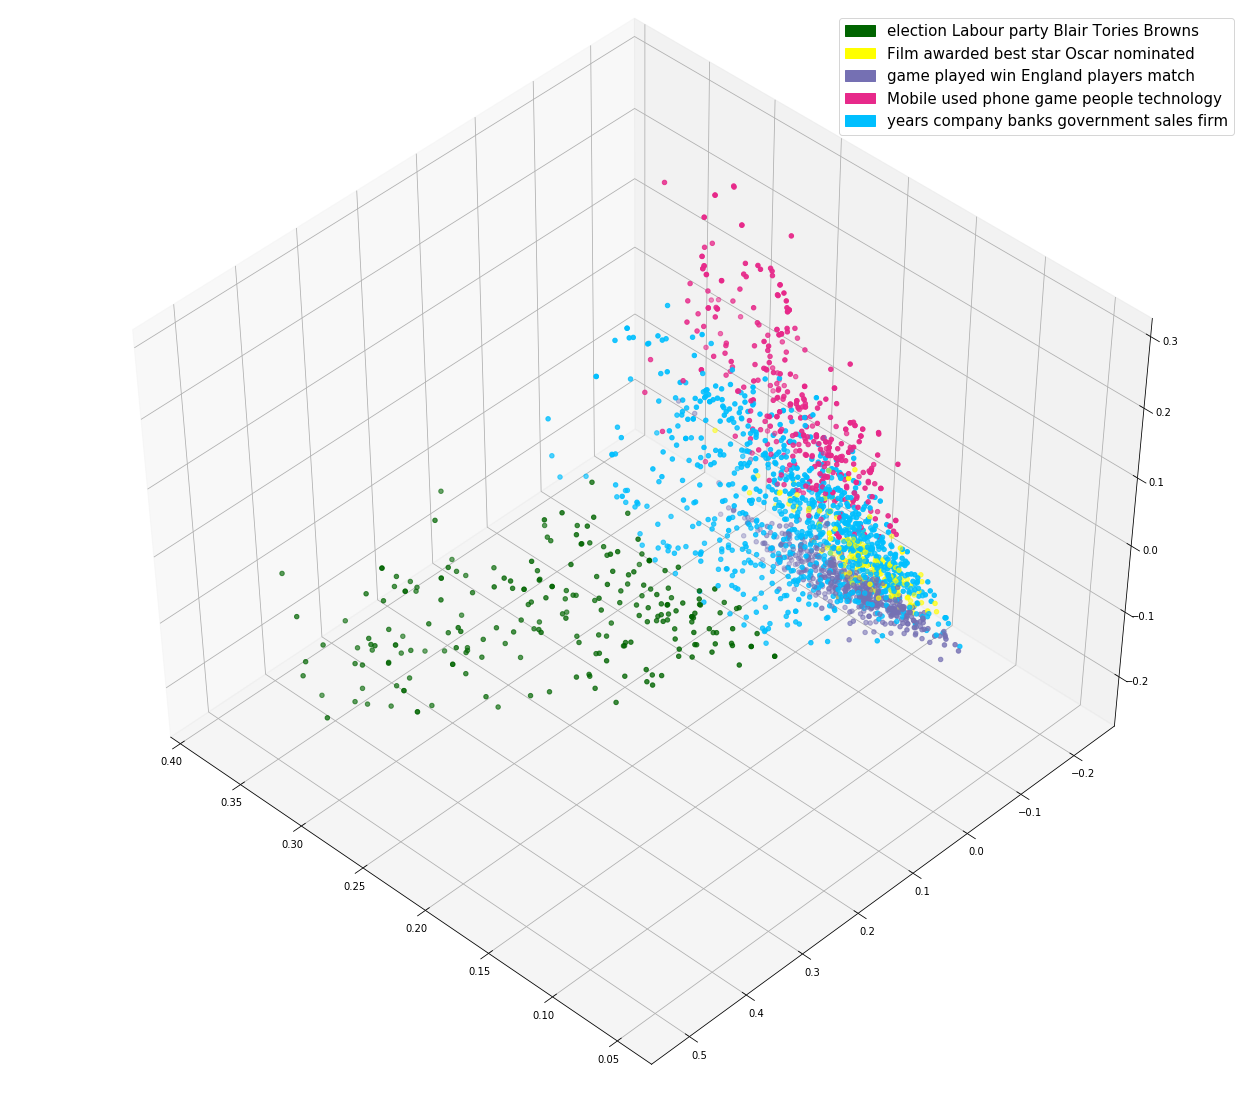

In [100]:
plot_LSA(text_tfidf,cluster_tfidf,feature_word)